# Modeling prevented plantings as a function of weather conditions and crop-progress reports

## Introduction

In this notebook, we will attempt to create a model to predict the area that will be claimed as "prevented plant" for a given year. Most often such prevented planting area is due to adverse weather conditions and thus we will base our model on environmental factors. Additionally, a weekly survery on planting progress is used.

Gro Intelligence catalogues and makes available a large number of sources of data through their web based product as well as through their API. This data allows for quick turnaround on creating models for predicting various agriculture related metrics and numbers. 

## Approach
Adverse weather conditions at planting time are the primary cause of planting prevent acres - like the flooding that impacted the US Corn Belt in 2019.

Prevented plant acres are reported at a county-level. Thus, we choose to treat the prevented plant of each county purely as a function of the weather conditions it has experienced and the state-level planting progress for that year. 

## Initial set-up

First we will define the crops we want to model prevented plant for, and include their respective id:s. In this case we use two separate items from the Gro ontology - the canonical ["Corn" (id:274)](https://app.gro-intelligence.com/dictionary/items/274) and ["Corn, Planted" (id:3231)](https://app.gro-intelligence.com/dictionary/items/3231) which represents "planted corn" and is the ID used in the planting progress data series. Both of these were taken from the Gro web interface "more information" function. 

In [1]:
crop = "corn"

crops = {
    "corn": {
        "progress_id": 3231,
        "id": 274
    },
    "soy": {
        "progress_id": 2904,
        "id": 270
    }
}

In [3]:
from api.client import Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
import pickle
from api.client.samples.prevented_plant import prevented_model_helpers
api_host = "api.gro-intelligence.com"
client = Client(api_host, os.environ["GROAPI_TOKEN"])

ImportError: No module named prevented_plant

In the following cells we fetch the [corn belt](https://app.gro-intelligence.com/dictionary/regions/100000100) states and county ids.

In [4]:
# get corn belt state ids
state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for 
    state_id 
    in client.lookup('regions', 100000100)["contains"]
}

state_ids_inv = {state_id: state_name for (state_name, state_id) in state_ids.items()}

In [5]:
# get the counties in each of these states
county_ids = {
    state_id: [county["id"] for county in client.get_descendant_regions(state_id, 5)]
    for state_id in state_ids.values()
}

In [6]:
# count number of counties
num_counties = 0
for state_id in state_ids.values():
    num_counties += len(county_ids[state_id])

We include a simple stub for saving and loading data already downloaded from the API locally

In [7]:
# stubs for saving/loading data
def s(data, name):
    with open(name + "_" + crop + ".pickle", "wb") as handle:
        pickle.dump(data, handle)
        
def l(name):
    with open(name + "_" + crop + ".pickle", "rb") as handle:
        return pickle.load(handle)

## STATE DATA

In [8]:
# Planting Progress for Corn (State)
try: 
    state_progress_data = l("state_progress_data")
except:
    print("no cached file")
    state_progress_data = {}
    for state_id in state_ids.values():
        state_progress_data[state_id] = client.get_data_points(**{
            'metric_id': 2860042, # planting progress
            'item_id': crops[crop]["progress_id"], # corn or soy depending on initial flag
            'region_id': state_id,
            'source_id': 25, # NASS
            'frequency_id': 2 # weekly
        })
        print(state_progress_data[state_id])

In [8]:
s(state_progress_data, "state_progress_data")

## COUNTY DATA

In [9]:
# soil moisture at a county level
try:
    county_smos_data = l("county_smos_data")
except:
    print("no cached file")
    county_smos_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_smos_data[county_id] = client.get_data_points(**{
                'metric_id': 15531082, # availability in soil
                'item_id': 7382, # soil moisture
                'region_id': county_id, # 
                'source_id': 43, # SMOS
                'frequency_id': 1 # daily
            })

In [45]:
s(county_smos_data, "county_smos_data")

In [10]:
# TRMM at a county level
try:
    county_trmm_data = l("county_trmm_data")
except:
    print("no cached file")
    county_trmm_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_trmm_data[county_id] = client.get_data_points(**{
                'metric_id': 2100031, # precip quantity
                'item_id': 2039, # rainfall (modelled)
                'region_id': county_id,  
                'source_id': 35, # TRMM
                'frequency_id': 1 # daily
            })

In [47]:
s(county_trmm_data, "county_trmm_data")

In [11]:
try:
    county_acreage_data = l("county_acreage_data")
except:
    # Acreage County corn/soy
    print("no cached data")
    county_acreage_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_acreage_data[county_id] = client.get_data_points(**{
                'metric_id': 2580001, # planted area
                'item_id': crops[crop]["id"], # corn or soy
                'region_id': county_id,
                'source_id': 25, # nass
                'frequency_id': 9, # yearly
            })

In [48]:
s(county_acreage_data, "county_acreage_data")

In [12]:
# define time period we are looking at
start_year = 2011
end_year = 2019
num_samples = end_year - start_year

features = {
    "state": {
        "area_planted_nass_final_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2580001, # area planted
            'source_id': 25, # NASS
            'frequency_id': 9 # yearly
        }
    },
    "county":{
        "fsa_area_failed_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850170, # area failed, irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_failed_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850175, # area failed, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_planted_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3280001, #area planted, irrig
            'source_id': 100, # FSA 
            'frequency_id': 9 # yearly
        },
        "fsa_area_planted_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3300001, # area planted, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_prevented_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850167, # area prevented, irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_prevented_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850172, # area prevented, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "area_planted_nass_final": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 2580001, # area planted
            'source_id': 25, # NASS
            'frequency_id': 9 # yearly
        }
    }
}

In [13]:
def get_features_list(features):
    features_list = []
    for region_type in ["state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            features_list.append("%s_%s" % (series_name, crop))
    return features_list

features_list = get_features_list(features)
num_features = len(features_list)
features_list_pd = pd.DataFrame(features_list)
features_list_pd.columns = ["feature name"]
display(features_list_pd)

,feature name
0,area_planted_nass_final_state_corn
1,fsa_area_failed_irrigated_corn
2,fsa_area_planted_irrigated_corn
3,area_planted_nass_final_corn
4,fsa_area_failed_non_irrigated_corn
5,fsa_area_planted_non_irrigated_corn
6,fsa_area_prevented_irrigated_corn
7,fsa_area_prevented_non_irrigated_corn


In [280]:
### adjust the width of the current notebook to be full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
def get_yearly_data():
    print("no cached data")
    print("proceeding to download {} features across {} states at a county level".format(num_features, len(state_ids)))

    yearly_data = np.ma.zeros((num_counties, num_samples, num_features))

    county_idx = -1
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_idx += 1
            feature_idx = 0

            # Get all the crop-specific data series
            for region_type in ["state", "county"]:
                for series_name, query in features[region_type].items():
                    
                    # this must be a set because ontology isn't necessarily a tree
                    useful_series = []

                    query["item_id"] = crops[crop]["id"]

                    if query['level'] == 5:
                        query['region_id'] = county_id
                    elif query['level'] == 4:
                        query['region_id'] = state_id
                    elif query['level'] == 3:
                        query['region_id'] = 1215

                    result = client.get_data_series(**query)

                    for possible_series in result: 
                        series_start_year = int(possible_series["start_date"][0:4])
                        series_end_year = int(possible_series["end_date"][0:4])

                        ################
                        # check for the three cases which would imply some overlap in dates between 
                        # our start_year and end_year of interest and the start and end year of the series.
                        if ((series_start_year <= start_year < series_end_year) 
                                                   or (series_start_year < end_year <= series_end_year)
                                                   or (start_year <= series_start_year and series_end_year <= end_year)):
                            useful_series.append(possible_series)

                    ################
                    # Some counties will inherently be missing data. For debugging missing data 
                    # uncomment following.
                    if not useful_series:
                        print("NO DATA FOUND FOR %s in %s for %s, county_idx=%i, feature=%i" % 
                             (series_name, state_id, crop, county_idx, feature_idx))
                    ################

                    for series in useful_series:

                        # now we can download the actual timeseries
                        data_points = client.get_data_points(**series)
                        number_sample_points = 0

                        cache = np.zeros(num_samples)

                        for point in data_points:
                            # if we have a sample date specified, let's pick the point that's closest to this point
                            last_sampled_date = None
                            last_reported_date = None

                            sample_deadline = \
                                datetime.datetime(int(point["end_date"][0:4]), query["sample_date"][0], query["sample_date"][1]) \
                                if "sample_date" in query else None 

                            report_deadline = \
                                datetime.datetime(int(point["end_date"][0:4]), query["report_date"][0], query["report_date"][1]) \
                                if "report_date" in query else None 

                            if "reporting_date" in point and point["reporting_date"] is not None:
                                reported_date = datetime.datetime.strptime(point["reporting_date"], '%Y-%m-%dT%H:%M:%S.%fZ')
                            else:
                                reported_date = None
                            end_date = datetime.datetime.strptime(point["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ')

                            sample_idx = int(point["end_date"][0:4]) - start_year

                            if 0 <= sample_idx < num_samples:

                                if sample_deadline is not None and end_date > sample_deadline :
                                    # continue to next point as this is after the date we want to grab it.
                                    continue
                                if last_sampled_date is not None and end_date < last_sampled_date:
                                    # newer sample date avail, ignoring this point
                                    continue
                                if report_deadline is not None and reported_date is not None and reported_date > report_deadline:
                                    # past report deadline
                                    continue
                                if last_reported_date is not None and reported_date < last_reported_date:
                                    # newer report date avail
                                    continue


                                # some items are item groups and thus need to be sum-aggregated
                                if (last_sampled_date is not None and end_date == last_sampled_date) and (last_reported_date is None or reported_date == last_reported_date):
                                    cache[sample_idx] +=  point["value"]
                                else:
                                    cache[sample_idx] = point["value"]
                                    last_sampled_date = end_date
                                    last_reported_date = reported_date

                                number_sample_points += 1

                        # masked + nonmasked => masked
                        yearly_data[county_idx, :, feature_idx] += cache
                        #print("downloaded %s in %s for %s, county_idx=%i, num_samples=%i, feature=%i" % 
                        #      (series_name, county_id, series["item_name"], county_idx, number_sample_points, feature_idx))

                    # download the next feature
                    feature_idx += 1
    return yearly_data

In [15]:
# Let's run it!
try:
    yearly_data = l("yearly_data")
except:
    yearly_data = get_yearly_data()

In [52]:
s(yearly_data, "yearly_data")

In [16]:
hectare_to_acre = client.lookup('units', 42).get('baseConvFactor').get('factor') \
    /client.lookup('units', 41).get('baseConvFactor').get('factor')

In [17]:
# area planted for corn,soy comes in hectares, not acres

yearly_data[:,:,features_list.index("fsa_area_planted_non_irrigated_" + crop)] *= hectare_to_acre
yearly_data[:,:,features_list.index("fsa_area_planted_irrigated_" + crop)] *= hectare_to_acre

In [18]:
denominator_features = [
    "fsa_area_prevented_non_irrigated_", #acre
    "fsa_area_prevented_irrigated_", #acre
    "fsa_area_planted_non_irrigated_", #hectare, but fixed to acre above
    "fsa_area_planted_irrigated_", #hectare, but fixed to acre above
    "fsa_area_failed_non_irrigated_", #acre
    "fsa_area_failed_irrigated_" #acre
] 

denominator_features = [feature_name + crop for feature_name in denominator_features]

denominator_idxs = []
for feature in denominator_features:
    denominator_idxs.append(features_list.index(feature))
    
def get_yearly_data_ratio(feature_name):
    numerator_idx = features_list.index(feature_name)

    yearly_data_ratio = yearly_data[:,:,numerator_idx] / np.sum(yearly_data[:,:,denominator_idxs], axis=2)

    # set any counties that have missing data to 0.. 
    yearly_data_ratio[yearly_data_ratio.mask] = 0.0
    return yearly_data_ratio

In [19]:
# "non-irrigated" prevented plant corn/soy acres vastly outnumber irrigated ones so we are using this as 
# the ratio of interest for the model.
yearly_data_ratio = get_yearly_data_ratio("fsa_area_prevented_non_irrigated_" + crop)

In [20]:
# Given weekly data of shape (num_weeks, some_data)
# returns an array of shape (num_years, 52, some_data)
#
# start_year should be year (absolute, i.e. 2011) you want output array indexing to start at
# num_years should be number of years from then you want outputted (don't exceed available data), (i.e. 2011 + 5 = 2016)
# epoch gives the date weekly_data starts being available (i.e. the starting monday of the first week)
def get_yearly(weekly_data, start_year, num_years, epoch):
    # weeky_data should have the first axis be some data that's over weeks.
    
    yearly_output = []
    
    for year_idx in range(num_years):
        first_day = datetime.date(start_year+year_idx, 1, 1)
        first_weekday = first_day.weekday()
        start_date = first_day - datetime.timedelta(first_weekday) if (first_weekday <= 3) else first_day + datetime.timedelta(6 - first_weekday + 1)
        start_week_idx = (start_date - epoch).days // 7
        pre_pad = 0 if 0 - start_week_idx < 0 else 0 - start_week_idx
        post_pad = 0 if (start_week_idx + 52 - len(weekly_data)) < 0 else (start_week_idx + 52 - len(weekly_data))
        weekly_data_for_year = np.lib.pad(weekly_data[start_week_idx:start_week_idx+52], (pre_pad, post_pad), 'constant', constant_values=(np.nan))
        yearly_output.append(weekly_data_for_year)
        
    return np.array(yearly_output)

# COMPUTATIONS / AVERAGES / SUMS

### compute  average crop acreage per county

In [23]:
# Compute 3-year average acreage in corn/soy for each county
county_acreage_3yr_avg = {}
county_acreage_3yr_avg_list = []
for county_id, county_dataseries in county_acreage_data.items():
    if not county_dataseries or county_dataseries[0] == {}:
        county_acreage_3yr_avg[county_id] = 0.0
        county_acreage_3yr_avg_list.append(0.0)
        continue
        
    # THIS IS IN HECTARES:
    assert county_acreage_data.values()[0][0]["unit_id"] == 42
    
    county_acreage_3yr_avg[county_id] = np.mean([point["value"] for point in county_dataseries[-3:]])*2.47105
    county_acreage_3yr_avg_list.append(np.mean([point["value"] for point in county_dataseries[-3:]])*2.47105)

county_acreage_3yr_avg_list = np.array(county_acreage_3yr_avg_list)

### compute + plot of SMOS weekly in corn belt

In [24]:
epoch_smos = datetime.date(2010,1,4)
epoch_today = datetime.datetime.today().date()
num_weeks = (epoch_today - epoch_smos).days//7
corn_belt_weekly = []
corn_belt_weekly_year = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        
        weekly_sum = np.zeros((num_weeks))
        weekly_count = np.zeros((num_weeks))
        weekly_progress = np.zeros((num_weeks))

        for datapoint in county_smos_data[county_id]:
            datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
            week_idx = (datapointdate - epoch_smos).days // 7
            
            assert(week_idx >= 0)
            weekly_sum[week_idx] += datapoint["value"]
            weekly_count[week_idx] += 1
            
        weekly_avg = weekly_sum / weekly_count
        #print(weekly_count)
        non_nan_idxs = np.where(~np.isnan(weekly_avg))[0]
        
        # this will interpolate the last week form the last last week, so be aware...
        current_week_nan = np.isnan(weekly_avg[-1])
        
        weekly_avg = np.interp(list(range(num_weeks)), non_nan_idxs, weekly_avg[non_nan_idxs])
        #if current_week_nan:
        #    weekly_avg[-1] = np.nan
        
        corn_belt_weekly.append(weekly_avg)
        corn_belt_weekly_year.append(get_yearly(weekly_avg, 2010, 10, epoch_smos))

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


Text(0.5,1,'corn belt weekly avg. soil moisture weighted by corn acreage')

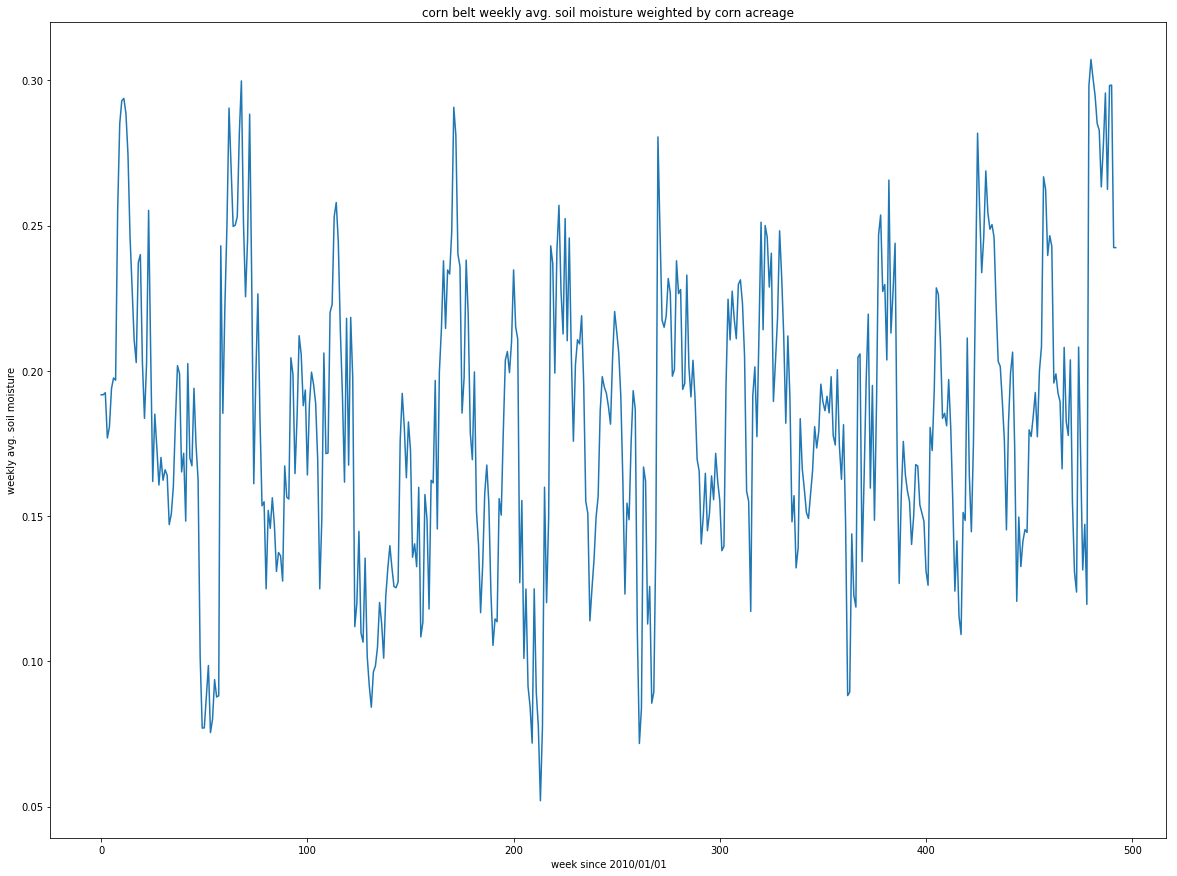

In [25]:
# corn belt weekly SMOS plot
fig, ax_corn = plt.subplots(1, 1, figsize=(20, 15))
corn_belt_weekly_avg = np.average(np.array(corn_belt_weekly), axis=0, weights=county_acreage_3yr_avg.values())

ax_corn.plot(corn_belt_weekly_avg)
ax_corn.set_xlabel("week since 2010/01/01")
ax_corn.set_ylabel("weekly avg. soil moisture")
ax_corn.set_title("corn belt weekly avg. soil moisture weighted by " + crop + " acreage")

### compute + plot of TRMM weekly in corn belt

In [26]:
# sum over weekly for trmm
epoch_trmm = datetime.date(2000,3,6)
epoch_today = datetime.datetime.today().date()
num_weeks = (epoch_today - epoch_trmm).days//7
corn_belt_weekly_trmm = []
corn_belt_weekly_year_trmm = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        
        weekly_sum = np.zeros((num_weeks))
        weekly_count = np.zeros((num_weeks))
        weekly_progress = np.zeros((num_weeks))

        for datapoint in county_trmm_data[county_id]:
            datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
            week_idx = (datapointdate - epoch_trmm).days // 7
            if week_idx >= len(weekly_sum) or week_idx<0:
                continue
            if not datapoint["value"]:
                continue
            weekly_sum[week_idx] += datapoint["value"]
            weekly_count[week_idx] += 1
    
        corn_belt_weekly_trmm.append(weekly_sum)
        corn_belt_weekly_year_trmm.append(get_yearly(weekly_sum, 2001, 19, epoch_trmm))

Text(0.5,1,'corn belt weekly summed rainfall weighted by corn acreage')

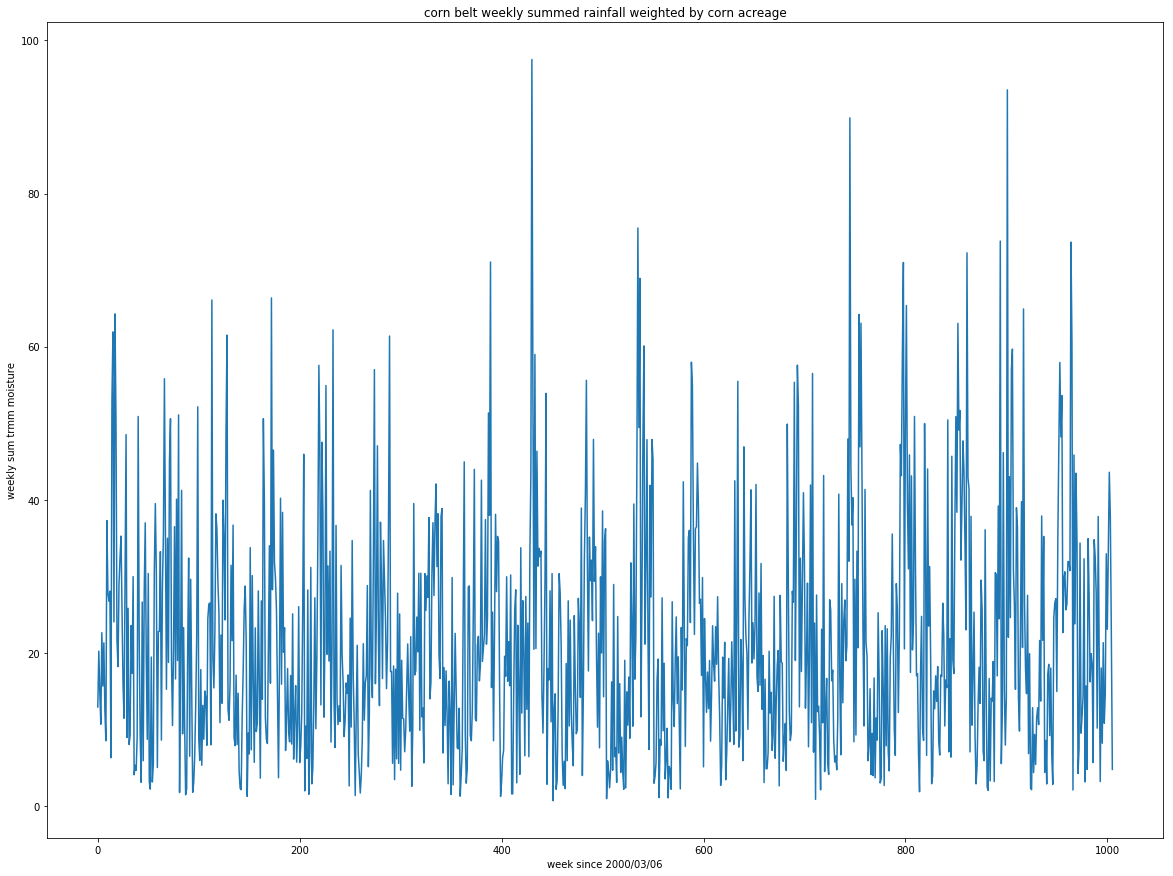

In [27]:
# corn belt weekly trmm visualization
fig, ax_corn = plt.subplots(1, 1, figsize=(20, 15))
corn_belt_weekly_trmm_avg = np.average(np.array(corn_belt_weekly_trmm), axis=0, weights=county_acreage_3yr_avg.values())

ax_corn.plot(corn_belt_weekly_trmm_avg)
ax_corn.set_xlabel("week since 2000/03/06")
ax_corn.set_ylabel("weekly sum trmm moisture")
ax_corn.set_title("corn belt weekly summed rainfall weighted by " + crop + " acreage")

### compute + plot weekly progress

In [28]:
# places progress in an np-array and fills in missing 0s and 100s at either tail 
corn_belt_progress_weekly = []

for state_id in state_ids.values():
    dataseries = state_progress_data[state_id]

    weekly_progress_sum = np.zeros((num_weeks))
    weekly_progress_count = np.zeros((num_weeks))
    
    for datapoint in dataseries:
        datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
        week_idx = (datapointdate - epoch_smos).days // 7
        if week_idx < 0:
            continue
        weekly_progress_sum[week_idx] = datapoint["value"]
        weekly_progress_count[week_idx] += 1
    
    weekly_progress_avg = weekly_progress_sum
    corn_belt_progress_weekly.append(get_yearly(weekly_progress_avg, 2010, 10, epoch_smos))
    
corn_belt_progress_weekly = np.array(corn_belt_progress_weekly)
end_weeks = np.argmax(np.flip(np.array(corn_belt_progress_weekly)>0.0, axis=2), axis=2)
for state_idx in range(corn_belt_progress_weekly.shape[0]):
    # (current year let's leave it at NAN)
    for year_idx in range(corn_belt_progress_weekly.shape[1]):
        end_idx = end_weeks[state_idx, year_idx]
        # we can't make any assumptions here on the last year...
        if year_idx == corn_belt_progress_weekly.shape[1] - 1:
            corn_belt_progress_weekly[state_idx, year_idx, -end_idx:] = np.nan
        else:
            corn_belt_progress_weekly[state_idx, year_idx, -end_idx:] = 100

Text(0.5,1,'corn progress average in corn belt over states and years')

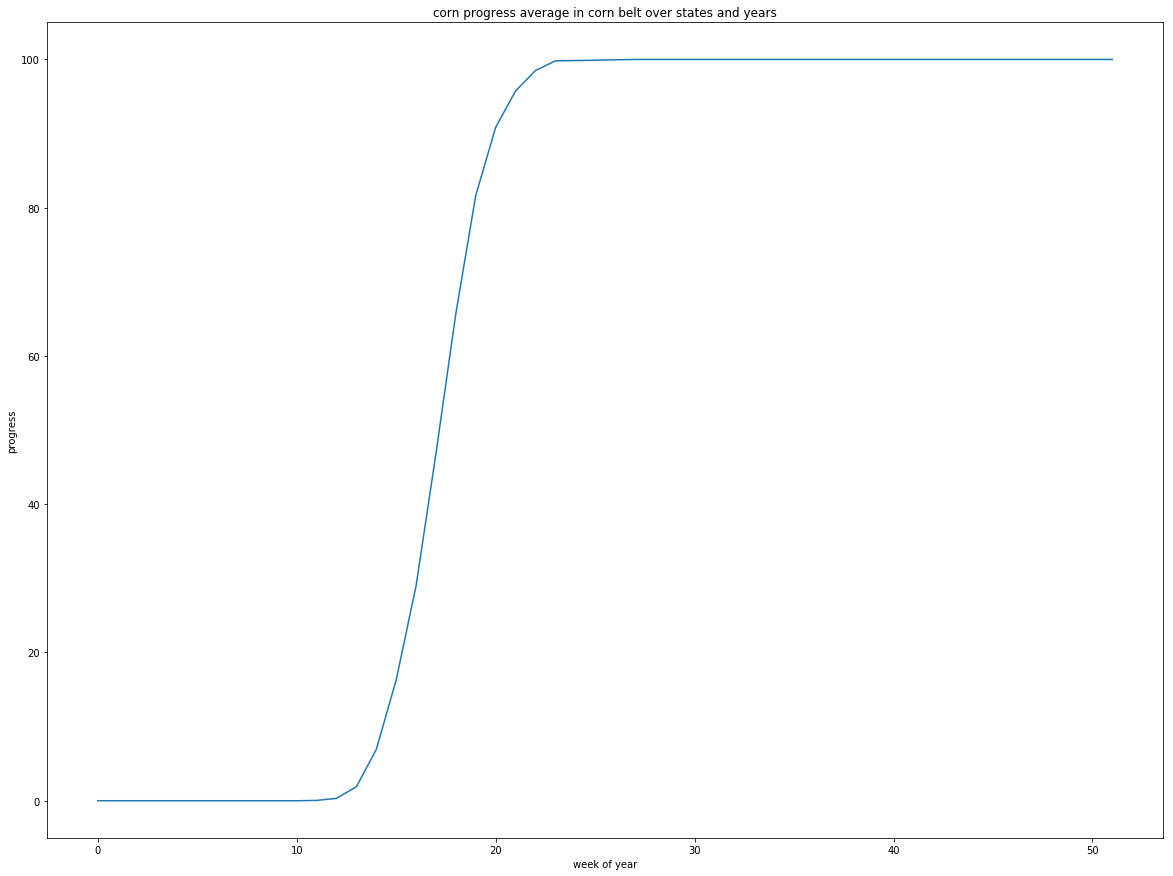

In [63]:
fig, ax_prog = plt.subplots(1, 1, figsize=(20, 15))
ax_prog.plot(np.mean(corn_belt_progress_weekly[:, :-1, :], axis=(0,1)))
ax_prog.set_xlabel("week of year")
ax_prog.set_ylabel("progress")
ax_prog.set_title(crop + " progress average in corn belt over states and years")

# Predict prevented/(prevented+failed+planted)

### simple linear model

In [29]:
# we alway use last weeks data for these sources, unless
# we specify an integer weekly lag in excess of that
lag_trmm = 0
lag_smos = 0
lag_prog = lag_progress = 0

simple linear model taking inputs from 2019-04-08 to 2019-04-22:
('county-level score:', 0.08771533017782529)


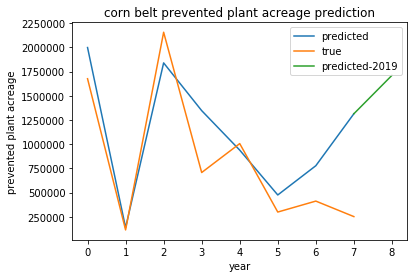

simple linear model taking inputs from 2019-04-08 to 2019-04-29:
('county-level score:', 0.09816963919344023)


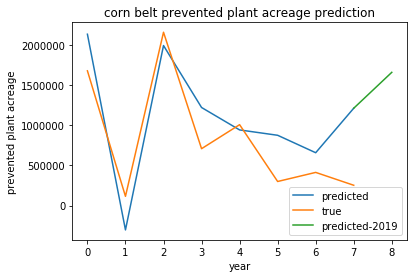

simple linear model taking inputs from 2019-04-08 to 2019-05-06:
('county-level score:', 0.11364430098933886)


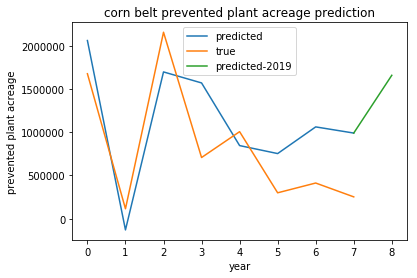

simple linear model taking inputs from 2019-04-08 to 2019-05-13:
('county-level score:', 0.14678677546723762)


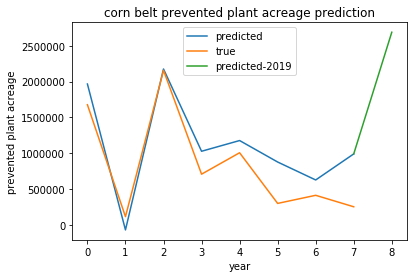

simple linear model taking inputs from 2019-04-08 to 2019-05-20:
('county-level score:', 0.1532611336812757)


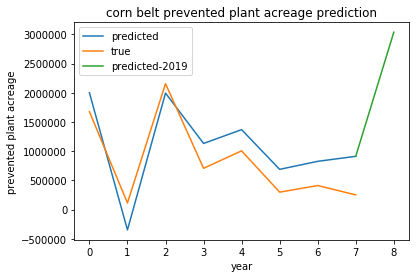

simple linear model taking inputs from 2019-04-08 to 2019-05-27:
('county-level score:', 0.17334803301129187)


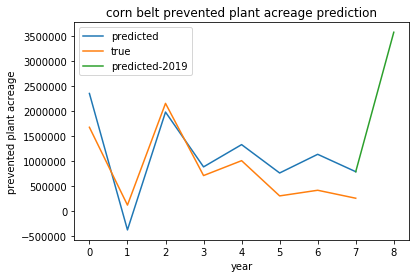

simple linear model taking inputs from 2019-04-08 to 2019-06-03:
('county-level score:', 0.19448203986140045)


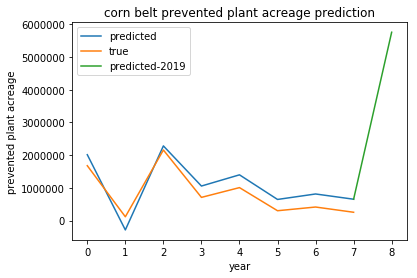

simple linear model taking inputs from 2019-04-08 to 2019-06-10:
('county-level score:', 0.22334022997644265)


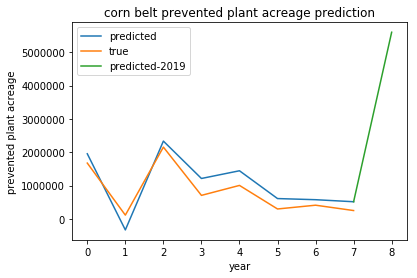

simple linear model taking inputs from 2019-04-08 to 2019-06-17:
('county-level score:', 0.2308802761187102)


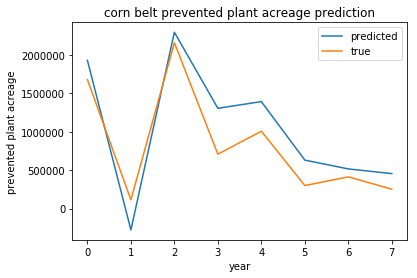

simple linear model taking inputs from 2019-04-08 to 2019-06-24:
('county-level score:', 0.25842236479005687)


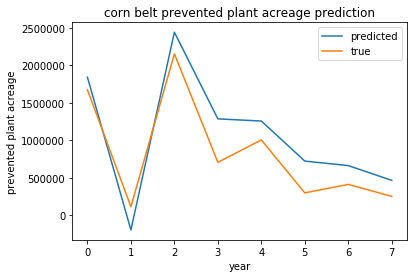

simple linear model taking inputs from 2019-04-08 to 2019-07-01:
('county-level score:', 0.25874875539911724)


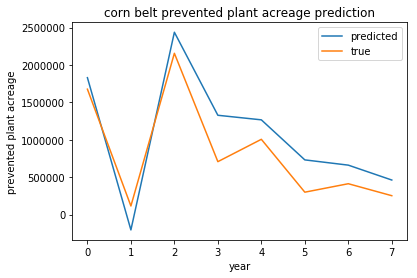

simple linear model taking inputs from 2019-04-08 to 2019-07-08:
('county-level score:', 0.25444732032119244)


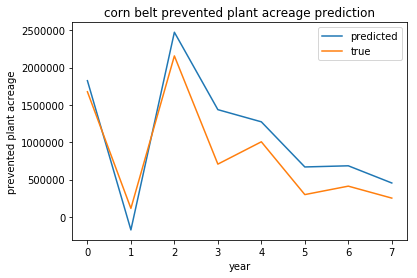

[1710555.4891781225, 1657310.688608765, 1658111.2036139981, 2688031.526034419, 3035661.5126255406, 3583420.7252606507, 5756623.768666254, 5602507.902576312]


In [30]:
import sklearn.linear_model
from sklearn.model_selection import train_test_split

# the predictor
yearly_data_ratio = get_yearly_data_ratio('fsa_area_prevented_non_irrigated_' + crop)

# the feature idx we will use to get back to real-world numbers instead of a ratio
numerator_idx = features_list.index('fsa_area_prevented_non_irrigated_' + crop) 

y = np.reshape(yearly_data_ratio, -1)

# X_yearly has shape (county_idx, year, feature_idx) and is composed of features:
# deviation SMOS up to that week
# deviation TRMM up to that week
# crop progress up to that week

# week 14 is first week of april this year
# week 26 is last week of june this year
start_week = 14
start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

curr_year_prediction_list = []

for week_offset in range(2,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("simple linear model taking inputs from {} to {}:".format(start_date, end_date))
    X_yearly = np.zeros((num_counties, 9, week_offset*3 - lag_progress - lag_smos - lag_trmm))
    X_yearly[:,:,:] = np.nan # catch bugs
    
    county_idx = 0
    for idx, state_id in enumerate(state_ids.values()):
        X_yearly[county_idx:county_idx+len(county_ids[state_id]),:,0:week_offset - lag_progress] = corn_belt_progress_weekly[idx,-9:,start_week:week_idx - lag_progress]
        county_idx += len(county_ids[state_id])

    X_yearly[:,:,week_offset - lag_progress:week_offset*2 - lag_progress - lag_trmm] = np.array(corn_belt_weekly_year_trmm)[:,-9:,start_week:week_idx - lag_trmm]
    X_yearly[:,:,week_offset*2 - lag_progress - lag_trmm:week_offset*3 - lag_progress - lag_trmm - lag_smos] = np.array(corn_belt_weekly_year)[:,-9:,start_week:week_idx - lag_smos]

    # Uncomment to weight by corn acreage ratio in that county
    # X_yearly[:,:,week_offset*2 - lag_progress - lag_trmm:week_offset*3 - lag_progress - lag_trmm - lag_smos] *= weight_corn[:, np.newaxis, np.newaxis]
    # X_yearly[:,:,week_offset - lag_progress:week_offset*2 - lag_progress - lag_trmm] *= weight_corn[:, np.newaxis, np.newaxis]
    
    # X_yearly conssists of:
    # 0:week_offset columns for smos
    # week_offset:week_offset*2 columns for trmm
    # week_offset*2: weekoffset*3 columns for crop progress
    
    X_truncated = X_yearly[:, :-1, :]
    X = np.reshape(X_truncated, (-1, X_truncated.shape[2]))
    
    # for polynomial features do:
    # X = np.concatenate((X, X**2), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    reg_linear = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
    print("county-level score:", reg_linear.score(X_test,y_test))
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = []
    
    for year in range(8, 0, -1):
        yearly_prevented_predictions.append(np.sum(reg_linear.predict(X_truncated[:, -year, :])*denominator_values_prediction[:, -year]))
    
    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    if not np.any(np.isnan(X_yearly[:, -1, :])):
        curr_year_prediction = reg_linear.predict(X_yearly[:, -1, :]) * np.mean(denominator_values_prediction[:, -3:], axis=1)
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.title("corn belt prevented plant acreage prediction")
    plt.xlabel("year")
    plt.ylabel("prevented plant acreage")
    plt.legend()
    plt.show()

print(curr_year_prediction_list)

### xgboost model

In [37]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
"""Creating a dataframe with desired features and target: 
smos: smos_week_i represents smos (deviation) of week i
trmm: trmm_week_i represents trmm (deviation) of week i
progress: prog_week_i represents planting progress (state level broadcasted to county level) of week i  
ratio: prevented acreage as a fraction of prevented+failed+planted
absolute: prevented acreage
"""
smos_cols = ['smos_week_'+str(i) for i in range(start_week+1, start_week+14-lag_smos)]
trmm_cols = ['trmm_week_'+str(i) for i in range(start_week+1, start_week+14-lag_trmm)]
prog_cols = ['prog_week_'+str(i) for i in range(start_week+1, start_week+14-lag_prog)]
features = prog_cols + trmm_cols + smos_cols
df_latestyear = pd.DataFrame(X_yearly[:,-1,:], columns=features)
df = pd.DataFrame(X, columns=features)
df.loc[:, 'ratio'] = y
y_absolute = np.reshape(yearly_data[:,:,numerator_idx], (-1))
df.loc[:, 'planted'] = np.reshape(denominator_values_prediction, (-1))
df.loc[:, 'absolute'] = y_absolute

In [32]:
# Analyst recommended patch to move ILLINOIS over IOWA in latestyear
iowa_state = client.lookup('regions', 13066)
illi_state = client.lookup("regions", 13064)
iowa_latlon = np.array((iowa_state.get("latitude"), iowa_state.get("longitude")))
illi_latlon = np.array((illi_state.get("latitude"), illi_state.get("longitude")))

delta_latlon = (iowa_latlon - illi_latlon)

In [33]:
"""Adding latitude and longitude as features
lat: latitude of the county
lon: longitude of the county
"""

import itertools
county_list = []
lat_list = []
lon_list = []
lat_list_patched = []
lon_list_patched = []
for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        county_list.append(county_id)
        county = client.lookup('regions', county_id)  
        lat_list.append(county.get('latitude'))
        lon_list.append(county.get('longitude'))
        
        lat_list_patched.append(county.get('latitude'))
        lon_list_patched.append(county.get('longitude'))
        
        # place illinois on top of iowa
        if state_id == 13064:
            lat_list_patched[-1] += delta_latlon[0]
            lon_list_patched[-1] += delta_latlon[1]

df.loc[:, 'region_id'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in county_list)))
df.loc[:, 'lat'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in lat_list)))
df.loc[:, 'lon'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in lon_list)))
df_latestyear.loc[:, 'lat'] = lat_list_patched
df_latestyear.loc[:, 'lon'] = lon_list_patched

In [34]:
df.loc[:, 'year'] = range(2011, 2019)*918

model taking inputs from 2019-04-08 to 2019-04-22:
county-level score for ratio r2: -0.0192415307732, mse: 0.00265409811311
county-level score for absolute r2: -0.0799029446628, mse: 17142476.8696
belt-level mean absolute deviation is: 503710.772982


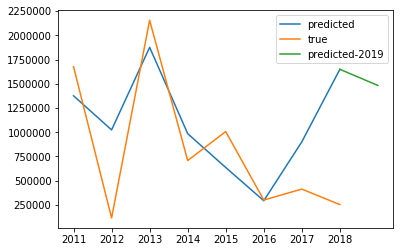

model taking inputs from 2019-04-08 to 2019-04-29:
county-level score for ratio r2: 0.0125475799491, mse: 0.0025713194819
county-level score for absolute r2: -0.164942598951, mse: 18492404.0217
belt-level mean absolute deviation is: 535926.092379


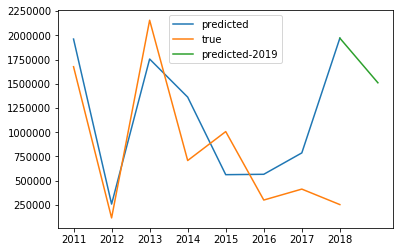

model taking inputs from 2019-04-08 to 2019-05-06:
county-level score for ratio r2: -0.027240844539, mse: 0.00267492827252
county-level score for absolute r2: -0.151902767232, mse: 18285408.5554
belt-level mean absolute deviation is: 604398.200915


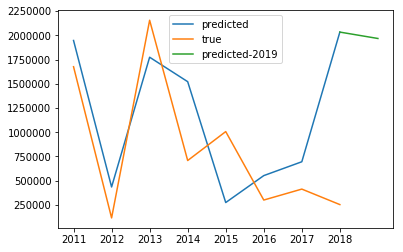

model taking inputs from 2019-04-08 to 2019-05-13:
county-level score for ratio r2: 0.101706327045, mse: 0.00233915070219
county-level score for absolute r2: 0.0168459428218, mse: 15606676.2923
belt-level mean absolute deviation is: 627311.384382


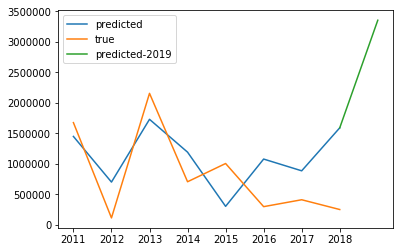

model taking inputs from 2019-04-08 to 2019-05-20:
county-level score for ratio r2: 0.110277582662, mse: 0.00231683121002
county-level score for absolute r2: 0.0920903896731, mse: 14412239.1476
belt-level mean absolute deviation is: 585036.70292


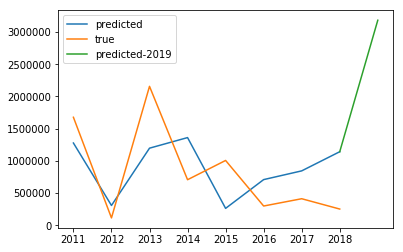

model taking inputs from 2019-04-08 to 2019-05-27:
county-level score for ratio r2: 0.177568369719, mse: 0.00214160645164
county-level score for absolute r2: 0.233443616205, mse: 12168385.2641
belt-level mean absolute deviation is: 532029.697043


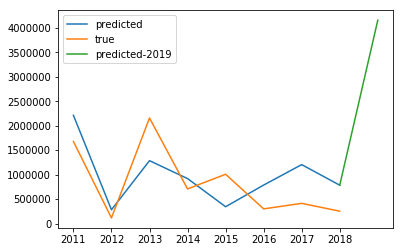

model taking inputs from 2019-04-08 to 2019-06-03:
county-level score for ratio r2: 0.183538016012, mse: 0.00212606153272
county-level score for absolute r2: 0.31241073978, mse: 10914854.0129
belt-level mean absolute deviation is: 364532.987984


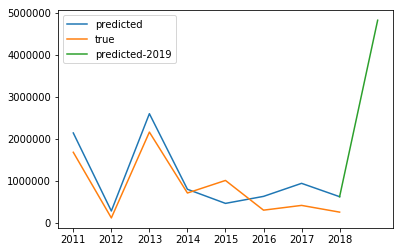

model taking inputs from 2019-04-08 to 2019-06-10:
county-level score for ratio r2: 0.214040932827, mse: 0.00204663214182
county-level score for absolute r2: 0.314441072708, mse: 10882624.3247
belt-level mean absolute deviation is: 418997.693725


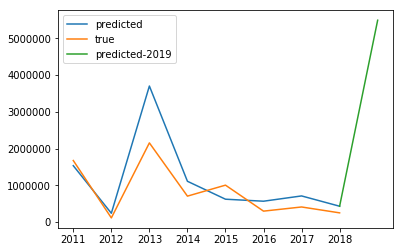

model taking inputs from 2019-04-08 to 2019-06-17:
county-level score for ratio r2: 0.21745303297, mse: 0.00203774705592
county-level score for absolute r2: 0.320254295071, mse: 10790344.7079
belt-level mean absolute deviation is: 427231.246115


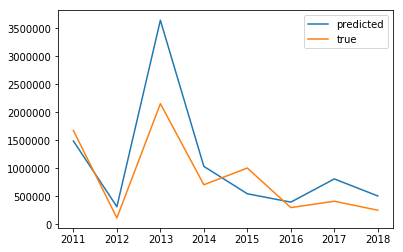

model taking inputs from 2019-04-08 to 2019-06-24:
county-level score for ratio r2: 0.247417994841, mse: 0.0019597184961
county-level score for absolute r2: 0.309557060335, mse: 10960153.5781
belt-level mean absolute deviation is: 301032.075521


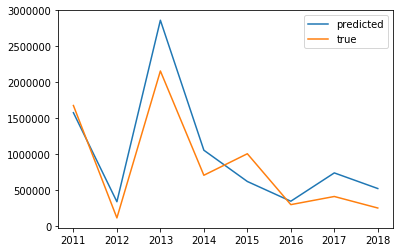

model taking inputs from 2019-04-08 to 2019-07-01:
county-level score for ratio r2: 0.255507521841, mse: 0.00193865342202
county-level score for absolute r2: 0.372736896443, mse: 9957231.154
belt-level mean absolute deviation is: 324245.309545


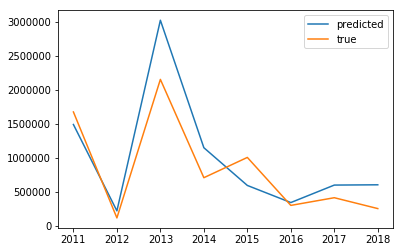

model taking inputs from 2019-04-08 to 2019-07-08:
county-level score for ratio r2: 0.263179683168, mse: 0.00191867516536
county-level score for absolute r2: 0.381776028219, mse: 9813743.15986
belt-level mean absolute deviation is: 275888.912432


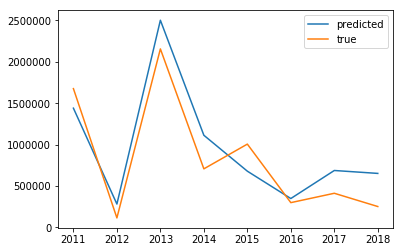

In [35]:
"""
Out of sample testing (leave one year out)
"""
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

metrics = ['belt_mae', 'county_ratio_r2', 'county_ratio_mse', 'county_absolute_r2', 'county_absolute_mse']
df_metrics = pd.DataFrame(columns=metrics)

curr_year_prediction_list = []

belt_mae_l = []
county_ratio_r2= []
county_ratio_mse = []
county_absolute_r2 = []
county_absolute_mse = []

for week_offset in range(2,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("model taking inputs from {} to {}:".format(start_date, end_date))

    features_week = prog_cols[:week_offset-lag_prog] + smos_cols[:week_offset-lag_smos] + trmm_cols[:week_offset-lag_trmm]
    features_week += ['lat', 'lon']
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = []    
    df.loc[:, 'pred_ratio'] = 0
    df.loc[:, 'pred_absolute'] = 0

    for year in range(8):
        # training on rows whose year column != year
        # predicting and scoring on rows whose year column == year
        test_year = 2011 + year
        reg = XGBRegressor()
        
        # uncomment to only train on counties with any corn/soy planted
        #df = df.loc[df.planted > 0.0]
        
        X_train = df.loc[df.year!=test_year, features_week]
        y_train = df.loc[df.year!=test_year, 'ratio']
        X_test = df.loc[df.year==test_year, features_week]
        y_test = df.loc[df.year==test_year, 'ratio']
        reg.fit(X_train,y_train)
        df.loc[df.year==test_year, 'pred_ratio'] = reg.predict(X_test)
        df.loc[df.year==test_year, 'pred_absolute'] = reg.predict(X_test)*denominator_values_prediction[:, -year]
        yearly_prevented_predictions.append(np.sum(reg.predict(X_test)*denominator_values_prediction[:, -year]))
    
    # plotting belt level aggregation
    ratio_r2 = r2_score(df['ratio'], df['pred_ratio'])
    county_ratio_r2.append(ratio_r2)
    ratio_mse = mean_squared_error(df['ratio'], df['pred_ratio'])
    county_ratio_mse.append(ratio_mse)
    print("county-level score for ratio r2: {}, mse: {}".format(ratio_r2, ratio_mse))
    absolute_r2 = r2_score(df['absolute'], df['pred_absolute'])
    county_absolute_r2.append(absolute_r2)
    absolute_mse = mean_squared_error(df['absolute'], df['pred_absolute'])
    county_absolute_mse.append(absolute_mse)
    print("county-level score for absolute r2: {}, mse: {}".format(absolute_r2, absolute_mse))
    belt_mae = mean_absolute_error(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), yearly_prevented_predictions)
    belt_mae_l.append(belt_mae)
    print("belt-level mean absolute deviation is: {}".format(belt_mae))
    df_metrics.loc[week_idx] = [belt_mae, ratio_r2, ratio_mse, absolute_r2, absolute_mse]

    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    # make predictions for the first 9 weeks
    if not np.any(np.isnan(df_latestyear.loc[:, features_week])):
        reg = XGBRegressor()
        reg.fit(df[features_week], df['ratio'])
        curr_year_prediction_ratio = reg.predict(df_latestyear.loc[:, features_week]) 
        curr_year_prediction = curr_year_prediction_ratio * np.mean(denominator_values_prediction[:, -3:], axis=1) # county_acreage_3yr_avg_list * 2.47105
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.xticks(range(8), range(2011, 2019))
    plt.legend()
    plt.show()

In [36]:
results_df = pd.DataFrame([["prediction_2019"] + curr_year_prediction_list,
                           ["belt_mae_l"] + belt_mae_l, 
                           ["county_ratio_r2"] + county_ratio_r2, 
                           ["county_ratio_mse"] + county_ratio_mse, 
                           ["county_absolute_r2"] + county_absolute_r2, 
                           ["county_absolute_mse"] + county_absolute_mse])

results_df.columns = ["metric"] + ["week {}".format(i) for i in range(1,13)]
results_df.set_index("metric")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(results_df)

,metric,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12
0,prediction_2019,1482641.141,1510147.479,1967644.785,3353839.279,3181587.941,4153872.763,4817155.511,5492867.952,nan,nan,nan,nan
1,belt_mae_l,503710.773,535926.092,604398.201,627311.384,585036.703,532029.697,364532.988,418997.694,427231.246,301032.076,324245.310,275888.912
2,county_ratio_r2,-0.019,0.013,-0.027,0.102,0.110,0.178,0.184,0.214,0.217,0.247,0.256,0.263
3,county_ratio_mse,0.003,0.003,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
4,county_absolute_r2,-0.080,-0.165,-0.152,0.017,0.092,0.233,0.312,0.314,0.320,0.310,0.373,0.382
5,county_absolute_mse,17142476.870,18492404.022,18285408.555,15606676.292,14412239.148,12168385.264,10914854.013,10882624.325,10790344.708,10960153.578,9957231.154,9813743.160


In [43]:
df_latestyear.loc[:, 'region_id'] = county_list
df_latestyear.loc[:, 'pred_absolute'] = curr_year_prediction

In [44]:
df_latestyear.to_csv('/home/ubuntu/eyvind/pp_corn_pred_06_20_2019.csv', index=False)

# CHOROPLETHS

In [ ]:
# Choropleth
import geopandas
import pandas as pd
import os
from shapely.geometry import shape

###
### GeoDataFrame has no simple support for loading a dict-of-json in python. Used workaround from here:
### https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe
###

gdf = geopandas.GeoDataFrame()
county_areas = []

df_district = geopandas.GeoDataFrame([
    {
        'district_id': county_id, 
        'geometries': shape(client.get_geojson(county_id)['geometries'][0])
    } 
    for state_id in state_ids.values() for county_id in county_ids[state_id]
])

df_district = df_district.set_geometry("geometries")
df_district.crs = {'init' :'epsg:4326'}
df_district["area"] = df_district["geometries"].to_crs({'init': 'epsg:3395'}).map(lambda p: (p.area / 10**4))
county_area = df_district["area"].tolist()

df_state = geopandas.GeoDataFrame([
    {
        'district_id': state_id, 
        'geometries': shape(client.get_geojson(county_id)['geometries'][0])
    } 
    for state_id in state_ids.values()
])

df_state = df_state.set_geometry("geometries")
df_state.crs = {'init' :'epsg:4326'}

In [250]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
musen_colors = [
    (89, 3, 4),
    (139, 13, 25),
    (186, 24, 44),
    (227, 51, 77),
    (237, 132, 147), 
    (249, 214, 218),
    (255, 255, 255), 
    (209, 224, 230), 
    (121, 163, 182),
    (34, 100, 135),
    (11, 73, 109),
    (8, 56, 92),
    (3, 41, 69)
]
musen_colors_blue = [
    (255, 255, 255),
    (175, 213, 227), 
    (97, 171, 199), 
    (47, 129, 163),
    (24, 85, 118), 
    (2, 41, 70)
]
musen_colors = np.array(musen_colors)/256.0
musen_colors_blue = np.array(musen_colors_blue)/256.0

musen_cmap = LinearSegmentedColormap.from_list('musen_red_blue', musen_colors, N=len(musen_colors)*10)

musen_cmap_blue = LinearSegmentedColormap.from_list('musen_blue', musen_colors_blue, N=len(musen_colors_blue)*10)

## Plot county-level prevented planting predictions

Text(0.5,1,'prevented plant acres prediction from week ending 06/10/2019')

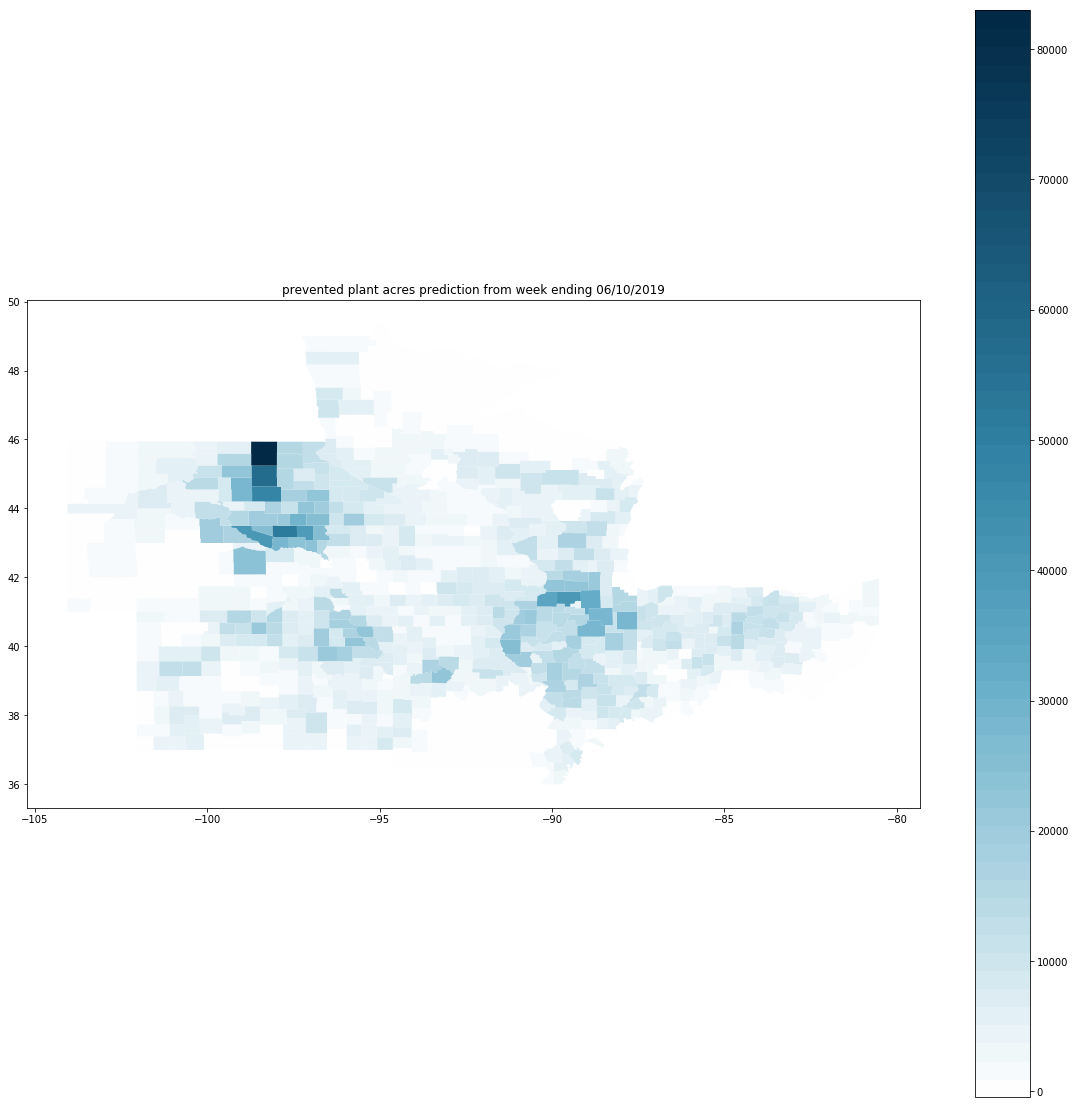

In [254]:
df_district["ratio"] = curr_year_prediction_ratio
df_district["prediction"] = curr_year_prediction
fix, ax = plt.subplots(1, 1, figsize=(20,20))
df_district.plot("prediction", legend=True, axes=ax, cmap=musen_cmap_blue)
ax.set_title("prevented plant acres prediction from week ending 06/10/2019")

## Plot county-level backtesting performance

In [255]:
week_offset = 8
week_idx = start_week + week_offset
end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()

print("model taking inputs from {} to {}:".format(start_date, end_date))

features_week = prog_cols[:week_offset-lag_prog] + smos_cols[:week_offset-lag_smos] + trmm_cols[:week_offset-lag_trmm]
features_week += ['lat', 'lon']

denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
yearly_prevented_predictions = []    
df.loc[:, 'pred_ratio'] = 0
df.loc[:, 'pred_absolute'] = 0
for year in range(8):
    # training on rows whose year column != year
    # predicting and scoring on rows whose year column == year
    test_year = 2011 + year
    reg = XGBRegressor()
    X_train = df.loc[df.year!=test_year, features_week]
    y_train = df.loc[df.year!=test_year, 'ratio']
    X_test = df.loc[df.year==test_year, features_week]
    y_test = df.loc[df.year==test_year, 'ratio']
    reg.fit(X_train,y_train)
    df.loc[df.year==test_year, 'pred_ratio'] = reg.predict(X_test)
    df.loc[df.year==test_year, 'pred_absolute'] = reg.predict(X_test)*denominator_values_prediction[:, -year]
    print("county-level score of year {}:".format(test_year), reg.score(X_test,y_test))
    yearly_prevented_predictions.append(np.sum(reg.predict(X_test)*denominator_values_prediction[:, -year]))
df.loc[:, 'deviation'] = abs(df['pred_absolute'] - df['absolute'])
df_deviation = df.groupby('region_id').mean()['deviation'].reset_index()
df_deviation = df_district.merge(df_deviation, left_on='district_id', right_on='region_id')

model taking inputs from 2019-04-08 to 2019-06-03:
('county-level score of year 2011:', 0.23370407395639314)
('county-level score of year 2012:', -2.1978951436360408)
('county-level score of year 2013:', 0.05144758263311422)
('county-level score of year 2014:', 0.32173514500793154)
('county-level score of year 2015:', 0.05265380481055393)
('county-level score of year 2016:', -0.1852586139299279)
('county-level score of year 2017:', 0.030443319091972953)
('county-level score of year 2018:', 0.23946514663941632)


Text(0.5,1,'mean absolute deviation from backtesting week ending 06/02/2019')

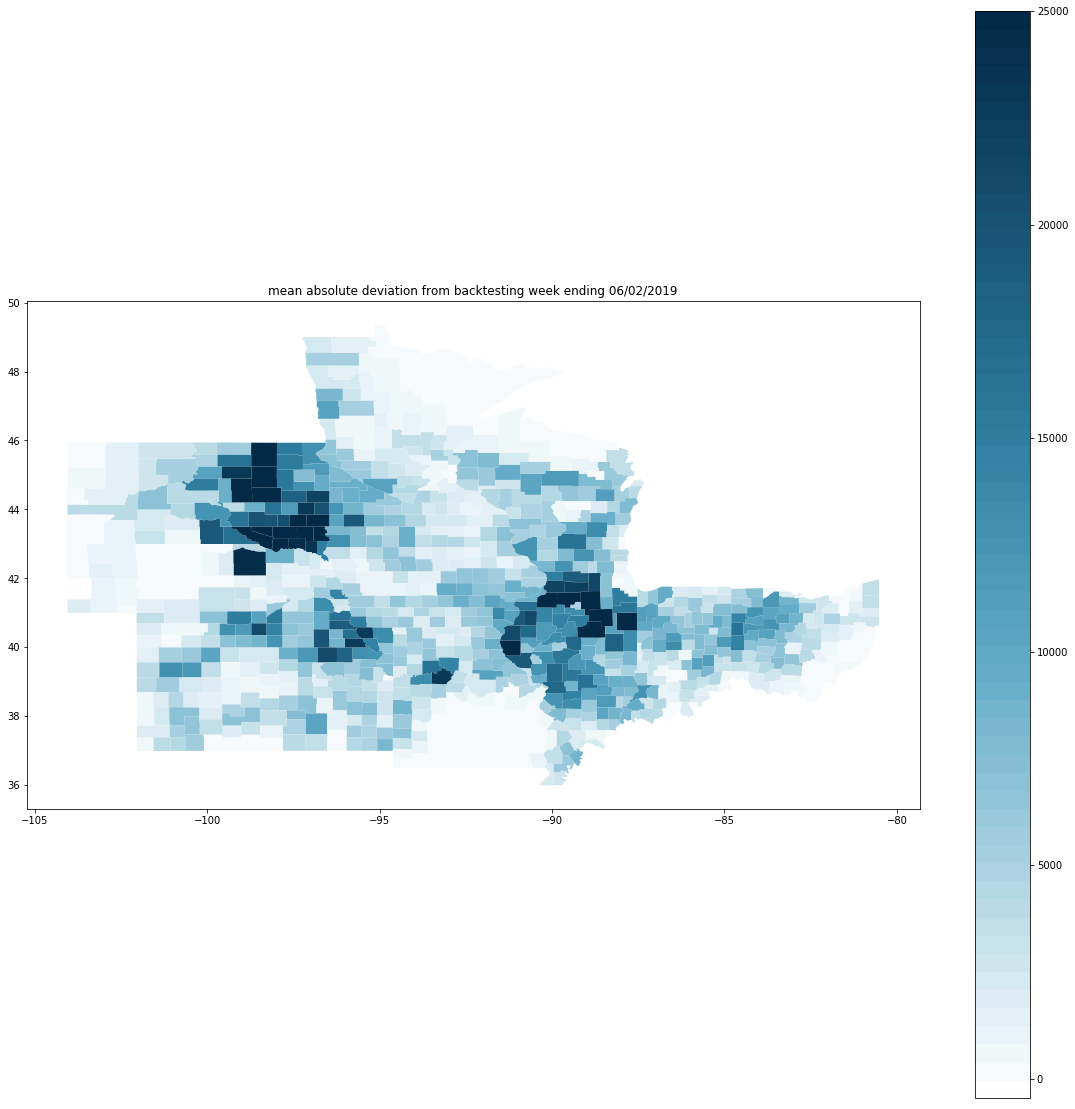

In [256]:
fix, ax = plt.subplots(1, 1, figsize=(20,20))
df_deviation.plot("prediction", legend=True, axes=ax, vmax=25000,cmap=musen_cmap_blue)
ax.set_title("mean absolute deviation from backtesting week ending 06/02/2019")